# **Imports**


In [1]:
# Custom libraries
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.CNNPreprocessor import CNNPreprocessor
from tools.CNNTrainer import CNNTrainer
from tools.CNNEvaluator import CNNEvaluator


# Custom PyTorch models
from models.PyTorchCNNClassifier import PyTorchCNNClassifier

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


# **Data Load**


In [3]:
# Initialize the data loader for a train dataset
train_loader = DataLoader(dataset_type="train", path="./db/seg_train")
train_dataset = train_loader.load_data()

# Initialize the data loader for a test dataset
test_loader = DataLoader(dataset_type="test", path="./db/seg_test")
test_dataset = test_loader.load_data()

# # Initialize the data loader for a val dataset
# val_loader = DataLoader(dataset_type="val", path="./db/seg_pred")
# val_dataset = val_loader.load_unlabeled_data()

In [4]:
print(f"Train dataset type: {type(train_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")
# print(f"Val dataset type: {type(val_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


# **EDA**


In [5]:
eda = EDA(train_dataset, train_dataset.classes)

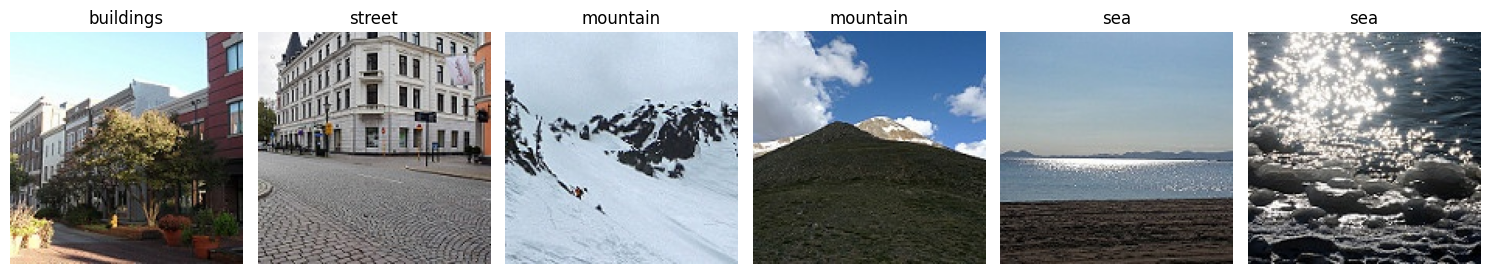

In [6]:
eda.show_sample_images(num_images=6)

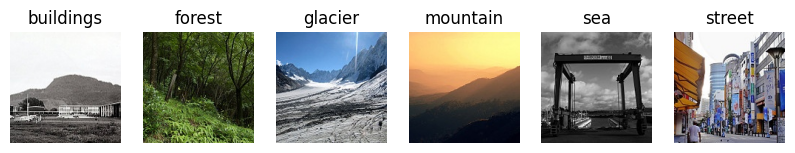

In [7]:
eda.show_images_from_each_class()

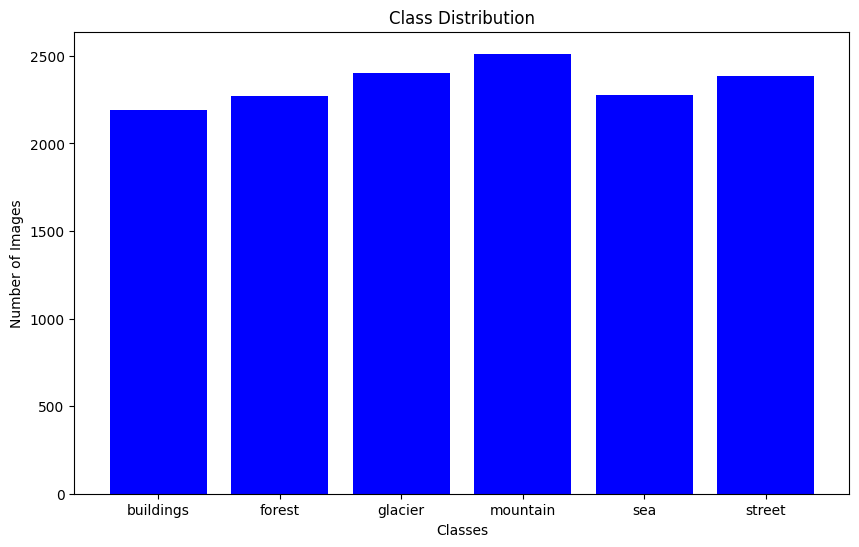

In [8]:
eda.plot_class_distribution()

In [9]:
eda.show_image_shape()

Shape of an image: torch.Size([3, 150, 150])


# **Preprocessing**


In [10]:
preprocessor = CNNPreprocessor()

In [11]:
preprocessor.help()

Available transformations and their parameters:
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| Transformation       | Description                                                          | Parameters                                                         |
+======================+======================================================================+====================================================================+
| ToGray               | Converts the image to grayscale.                                     | None: No parameters. Converts to grayscale using luminance.        |
+----------------------+----------------------------------------------------------------------+--------------------------------------------------------------------+
| RandomResizedCrop    | Randomly crops a part of the image and resizes it to the given size. | size: (int): Target size of the

In [12]:
preprocessor.set_transform_settings(
    train_transform_settings={
        "RandomResizedCrop": {"enabled": True, "size": 224},
        "RandomHorizontalFlip": {"enabled": True, "p": 0.5},
        "VerticalFlip": {"enabled": True, "p": 0.5},
        "ColorJitter": {
            "enabled": True,
            "brightness": 0.5,
            "contrast": 0.5,
            "saturation": 0.5,
            "hue": 0.2,
        },
        "GaussianBlur": {"enabled": True, "kernel_size": (5, 9), "sigma": (0.1, 5)},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    test_transform_settings={
        "Resize": {"enabled": True, "size": 256},
        "CenterCrop": {"enabled": True, "size": 224},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    # val_transform_settings={
    #     "Normalize": {
    #         "enabled": True,
    #         "mean": [0.485, 0.456, 0.406],
    #         "std": [0.229, 0.224, 0.225],
    #     },
    # },
)

In [13]:
img_train, label_img_train = train_dataset[0]
img_test, label_test = test_dataset[0]
# img_val = val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
# print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>


In [14]:
transformed_train_dataset = preprocessor.transform_dataset(
    train_dataset, dataset_type="train"
)

transformed_test_dataset = preprocessor.transform_dataset(
    test_dataset, dataset_type="test"
)

In [15]:
print(f"Train dataset type: {type(transformed_train_dataset)}")
print(f"Test dataset type: {type(transformed_test_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


In [16]:
# transformed_val_dataset = preprocessor.transform_unlabeled_data(val_dataset)

In [17]:
# print(f"Val dataset type: {type(transformed_val_dataset)}")

In [18]:
img_train, label_img_train = transformed_train_dataset[0]
img_test, label_test = transformed_test_dataset[0]
# img_val = transformed_val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
# print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>


In [19]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [20]:
model = PyTorchCNNClassifier(
    input_channels=3, num_classes=num_classes, random_state=42, epochs_logger=True
)

In [21]:
param_grid = {
    "conv_layers": [[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]],
    "hidden_sizes": [[256, 128]],
    "lr": [0.001],
    "batch_size": [16],
    "epochs": [10],
    "dropout_rate": [0.1],
    "optimizer_type": ["adam"],
    "activation_fn": ["ReLU"],
    "pool_fn": ["AvgPool2d"],
    "pool_kernel_size": [2],
    "pool_stride": [2],
    "pool_padding": [1],
}

In [22]:
models = {"cnn_model": model}
param_grids = {"cnn_model": param_grid}

# **Model Training**


In [23]:
model_trainer = CNNTrainer(device="cuda")

In [24]:
model_trainer.help()

=== CNNTrainer Help ===
This trainer is designed to support classification tasks using PyTorch CNN models.

Usage:
1. Initialize the CNNTrainer with the device ('cpu' or 'cuda').
   Example:
       trainer = CNNTrainer(device='cuda')

2. Create model objects and define the parameter grid for hyperparameter tuning.
   Example:
       param_grid = { "lr": [0.001, 0.01], "epochs": [10, 20] }

3. Call the `train` method with the training and test datasets, models, and parameter grid.
   Example:
       trainer.train(train_dataset, test_dataset, models={'cnn_model': model}, param_grids={'cnn_model': param_grid})


In [25]:
model_trainer.train(
    train_dataset=transformed_train_dataset,
    test_dataset=transformed_test_dataset,
    models=models,
    param_grids=param_grids,
    scoring="accuracy",
    verbose=1,
    use_progress_bar=True,
)

Training on device: cuda


Total Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Training cnn_model with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}
Training with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}

Epoch 1/10


Total Training Progress:  10%|█         | 1/10 [01:10<10:37, 70.80s/it]

Training Loss: 1.1791087876419815, Training Accuracy: 0.5324925181701582
Validation Loss: 0.9087186404999267, Validation Accuracy: 0.6696666666666666

Epoch 2/10


Total Training Progress:  20%|██        | 2/10 [02:29<10:05, 75.68s/it]

Training Loss: 0.8974451907403377, Training Accuracy: 0.6619638021946701
Validation Loss: 0.661755546233914, Validation Accuracy: 0.7626666666666667

Epoch 3/10


Total Training Progress:  30%|███       | 3/10 [03:48<08:59, 77.11s/it]

Training Loss: 0.7939905254233942, Training Accuracy: 0.7042183269203364
Validation Loss: 0.5995184149830899, Validation Accuracy: 0.78

Epoch 4/10


Total Training Progress:  40%|████      | 4/10 [05:07<07:46, 77.83s/it]

Training Loss: 0.7402684610158816, Training Accuracy: 0.7305116146501354
Validation Loss: 0.589846991180898, Validation Accuracy: 0.791

Epoch 5/10


Total Training Progress:  50%|█████     | 5/10 [06:26<06:31, 78.25s/it]

Training Loss: 0.7011661267497816, Training Accuracy: 0.7431950976200655
Validation Loss: 0.5387259745930738, Validation Accuracy: 0.8023333333333333

Epoch 6/10


Total Training Progress:  60%|██████    | 6/10 [07:45<05:13, 78.42s/it]

Training Loss: 0.6580648781373197, Training Accuracy: 0.7568761579022374
Validation Loss: 0.4852527705358064, Validation Accuracy: 0.826

Epoch 7/10


Total Training Progress:  70%|███████   | 7/10 [09:04<03:55, 78.61s/it]

Training Loss: 0.6430072320247565, Training Accuracy: 0.7620778110303549
Validation Loss: 0.45532377154511855, Validation Accuracy: 0.8396666666666667

Epoch 8/10


Total Training Progress:  80%|████████  | 8/10 [10:23<02:37, 78.86s/it]

Training Loss: 0.6329872669961838, Training Accuracy: 0.7684195525153199
Validation Loss: 0.4398391856589018, Validation Accuracy: 0.8486666666666667

Epoch 9/10


Total Training Progress:  90%|█████████ | 9/10 [11:42<01:18, 78.87s/it]

Training Loss: 0.6133789965344045, Training Accuracy: 0.7745475274333761
Validation Loss: 0.44644094195633016, Validation Accuracy: 0.845

Epoch 10/10


Total Training Progress: 100%|██████████| 10/10 [13:01<00:00, 78.94s/it]

Training Loss: 0.5942449643529086, Training Accuracy: 0.7811742910075531


Total Training Progress: 100%|██████████| 10/10 [13:10<00:00, 79.02s/it]

Validation Loss: 0.41598661959002864, Validation Accuracy: 0.8523333333333334
Validation Accuracy for cnn_model: 0.7811742910075531

Best Model: cnn_model with score: 0.7811742910075531


In [26]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model_name = model_trainer.best_model_name

In [27]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)

{'cnn_model': <models.PyTorchCNNClassifier.PyTorchCNNClassifier object at 0x0000024593E67800>}
{'cnn_model': {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}}
{'cnn_model': 0.7811742910075531}
cnn_model


# **Model Evaluator**


In [28]:
evaluator = CNNEvaluator()

In [29]:
evaluator.visualize_pipeline(model_name=best_model_name, best_models=best_models)

Visualizing the architecture of the model: cnn_model
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─AvgPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─AvgPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─AvgPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           27,558,144
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           32,896
├─ReLU: 1-15                             --
├─Dropout: 1-16                          --
├─Linear: 1-17                           774
Total params: 27,685,062
Trainable params: 27,685,062
Non-trainable params: 0


In [30]:
evaluator.display_results(
    test_dataset=transformed_test_dataset,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Validation Loss: 0.41598661959002864, Validation Accuracy: 0.8523333333333334
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.852333,0.85474,0.852284,0.853551,0.852333



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,10,"[256, 128]",0.001,adam,AvgPool2d,2,1,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.781174



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


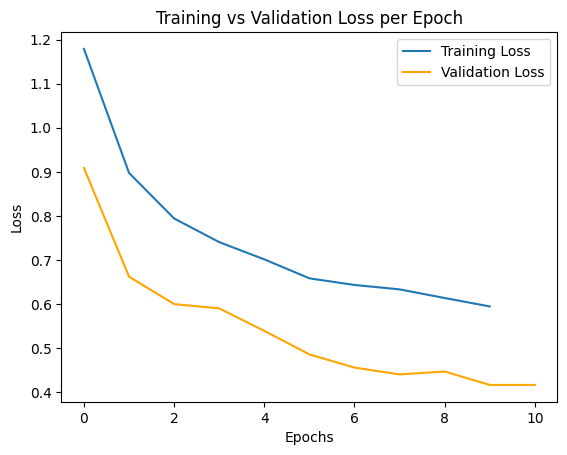

In [31]:
evaluator.plot_loss_history(best_models, best_model_name)

In [32]:
# evaluator.predict_on_val(
#     val_dataset=transformed_val_dataset,
#     best_models=best_models,
#     best_model_name=best_model_name,
# )

# **Key Conclusions:**

# **High Model Accuracy:**

**Validation Accuracy:** The model achieved a validation accuracy of 85.53%. This suggests that the model generalizes well to unseen data, correctly predicting the outcomes in most cases.

**Evaluation on Test Set:** The model achieved an accuracy of 0.855 on the test set. Additionally, other evaluation metrics, such as Balanced Accuracy (0.8549), F1 Score (0.8545), Precision (0.8566), and Recall (0.8553), demonstrate that the model performs consistently across different aspects of prediction quality.

# **Optimal Hyperparameters:**

**Best Architecture:** A 3-layer architecture with convolutional layers [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)] performed the best.

**Hyperparameter Tuning:** The optimal model was achieved with a batch size of 16, a learning rate of 0.001, ReLU activation functions, and Adam optimizer. A dropout rate of 0.1 helped to prevent overfitting, and MaxPooling (kernel size = 2, stride = 2, padding = 0) was used to reduce the spatial dimensions effectively.

# **Regularization and Loss Function:**

**Regularization:** The use of dropout after each hidden layer (with a dropout rate of 0.1) proved to be effective in preventing overfitting. This acts as a form of regularization by randomly dropping units during training.

**Optimizer and Loss Function:** The combination of Adam optimizer and the MSE loss function resulted in effective optimization of the model parameters.

**Cross-Validation Score:**
The cross-validation score for the best model was 0.783, indicating that while the model performed well during cross-validation, there is still some room for improvement in terms of generalization.
